# DBScan

## Env

### spark env

In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)

### python env

In [3]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

## Global Variant

In [4]:
UNTAGGED = 0
TAGGED = 1
INIT_TAG = -1
CORE = 1
UNCLASSIFIED = 0
BOUNDARY = 0
CORE = 1
NOISE = -1
TRADITIONAL = "traditional"
ADVANCED = "advanced"

## Partition

In [5]:
def partition(dataset,partition_shape,eps):
    df=dataset.toDF().toPandas()
    true_tags=[]
    point_x=[]
    point_y=[]
    partition_num=partition_shape[0]*partition_shape[1]
    for i in range(0, df.shape[0]):
        point_x.append(float(df.iloc[i,0]))
        point_y.append(float(df.iloc[i,1]))
        true_tags.append(float(df.iloc[i,2]))
    border_x=np.linspace(min(point_x),max(point_x),num=partition_shape[0]+1, endpoint=True)
    border_y=np.linspace(min(point_y),max(point_y),num=partition_shape[1]+1, endpoint=True)
    
    lower_bound_list = []
    upper_bound_list = []
    
    for y_low in border_y[:-1]:
        for x_low in border_x[:-1]:
            lower_bound_list.append([x_low,y_low])

    lower_bound = []
    for lower in lower_bound_list:
        lower_bound.append([lower[0]-eps, lower[1]-eps])

    for y_up in border_y[1:]:
        for x_up in border_x[1:]:
            upper_bound_list.append([x_up,y_up])

    upper_bound = []
    for upper in upper_bound_list:
        upper_bound.append([upper[0]+eps, upper[1]+eps])
        
    partition_info={}
    for i in range(0,len(lower_bound)):
        partition_info[i]=[]
    for p_id in range(0,df.shape[0]):     # index of point in dataset
        for part_id in range(0,len(lower_bound)):
            if (point_x[p_id]>lower_bound[part_id][0]) \
            and (point_y[p_id]>lower_bound[part_id][1])\
            and (point_x[p_id]<upper_bound[part_id][0])\
            and (point_y[p_id]<upper_bound[part_id][1]):
                partition_info[part_id].append((p_id,(point_x[p_id],point_y[p_id])))
            else:
                continue
    res = sc.parallelize(list(partition_info.items()),partition_num)

    return res

## Local DBScan

### get the neighbours points

In [30]:
##calculate the neighbours of point p
def get_neighbours(dataset, pid, eps, num_p, method=ADVANCED):
    neighbours = []
    point_array = np.array(dataset)
    if method == TRADITIONAL:
        for nid in range(num_p):
            distance = np.linalg.norm(point_array[pid] - point_array[nid])
            if distance < eps:
                neighbours.append(nid)
        return neighbours

    elif method == ADVANCED:
        s = 1.25 * eps * math.sqrt(2)  ##2.5*（1/根号2）
        distance = eps + 1
        for nid in range(num_p):
            if (point_array[pid][0] - s) <= point_array[nid][0] and point_array[nid][0] <= (point_array[pid][0] + s):
                if (point_array[pid][1] - s) <= point_array[nid][1] and point_array[nid][1] <= (point_array[pid][1] + s):
                    distance = np.linalg.norm(point_array[pid] - point_array[nid])

            if distance < eps:
                neighbours.append(nid)
        return neighbours

### local cluster

In [7]:
def cluster(rdd_list, eps, minpts, method =TRADITIONAL):
    # data_list = [pid for pid in range(num_p)]
    point_id_list = []
    dataset = []
    for point in rdd_list:
        point_id_list.append(point[0])
        dataset.append(point[1])
    num_p = len(point_id_list)  # num_p represents the number of points
    tag_list = [UNCLASSIFIED] * num_p
    core_list = [BOUNDARY] * num_p
    noise_list = []
    cluster_id = 1
    for pid in range(num_p):
        if tag_list[pid] == UNCLASSIFIED:
            neighbour = get_neighbours(dataset, pid, eps, num_p, method)
            if len(neighbour) < minpts:
                noise_list.append(pid)
            else:
                tag_list[pid] = cluster_id
                for nid in neighbour:
                    if tag_list[nid] == UNCLASSIFIED:
                        tag_list[nid] = cluster_id

                    if nid in noise_list:
                        noise_list.remove(nid)

                while len(neighbour) > 0:
                    cid = neighbour[0]  # current point id
                    sub_neighbour = get_neighbours(dataset, cid, eps, num_p, method)
                    if len(sub_neighbour) >= minpts:
                        for sid in range(len(sub_neighbour)):
                            if sub_neighbour[sid] in noise_list:
                                noise_list.remove(sub_neighbour[sid])
                            if tag_list[sub_neighbour[sid]] == UNCLASSIFIED:
                                neighbour.append(sub_neighbour[sid])
                                tag_list[sub_neighbour[sid]] = cluster_id
                    elif len(sub_neighbour) < minpts:
                        core_list[cid] = CORE

                    neighbour = neighbour[1:]
                cluster_id += 1

    for nid in noise_list:
        tag_list[nid] = NOISE

    return (tag_list, core_list)

## Merge

In [8]:
def merge(partition_dict, core_list):
    max_point_tags = 0
    tagged_point_id = []
    tagged_partition_id = []
    status = []
    for partition_key, partition_value in partition_dict.items():
        max_tags = max_point_tags
        for point_key, point_value in partition_value.items():
            if point_value["tags"] != NOISE:
                point_value["tags"] += max_point_tags  # make different partition has different tags.
            if point_value["tags"] > max_tags:
                max_tags = point_value["tags"]  # update max_point_tags.
            point_value["is_tagged"] = UNTAGGED
            point_value["final_tags"] = INIT_TAG
        max_point_tags = max_tags

    for partition_key, partition_value in partition_dict.items():
        for point_key, point_value in partition_value.items():
#             if point_value["is_tagged"] == UNTAGGED:
            if point_key not in tagged_point_id:
                point_value["is_tagged"] = TAGGED
                point_value["final_tags"] = point_value["tags"]
                tagged_point_id.append(point_key)
                tagged_partition_id.append(partition_key)

            else: 
                position = tagged_point_id.index(point_key)
                initial_tags = point_value["tags"]
                point_value["is_tagged"] = TAGGED
                if partition_dict[tagged_partition_id[position]][tagged_point_id[position]]["final_tags"] == NOISE:
                    partition_dict[tagged_partition_id[position]][tagged_point_id[position]]["final_tags"] = initial_tags
                else:
                    point_value["final_tags"] = partition_dict[tagged_partition_id[position]][tagged_point_id[position]]["final_tags"]
                for point_key2, point_value2 in partition_value.items():
                    if point_value2["tags"] == initial_tags and initial_tags != NOISE:
                        point_value2["final_tags"] = partition_dict[tagged_partition_id[position]][tagged_point_id[position]]["final_tags"]
                        if point_key2 not in tagged_point_id:
                            tagged_point_id.append(point_key2)
                            tagged_partition_id.append(partition_key)
        

    return partition_dict

## Main

In [9]:
def main(dataset, partition_shape, eps, minpoint):
    partitioned_data = partition(dataset, partition_shape, eps)
    partitioned_data_list = partitioned_data.collect()
    # rdd = [(partition_id, [(point_id, (x, y)), ]), () ...]
    cluster_results = partitioned_data.mapValues(lambda x: cluster(x, eps, minpoint, method =TRADITIONAL)).collect()
    # cluster_result =[(partition_id , (tag_list , core_list)),...]
    #print(cluster_results)
    core_list = []
    tag_list = []
    for cluster_result in cluster_results:
        tag_list += cluster_result[1][0]
        core_list += (cluster_result[1][1])
    partition_id_list = []
    point_id_list = []
    coordinate_list = []
    for pp in partitioned_data_list:
        point_id_tmp = []
        coordinate_tmp = []
        for p in pp[1]:
            point_id_tmp.append(p[0])
            coordinate_tmp.append(p[1])
            partition_id_list.append(pp[0])
        point_id_list += (point_id_tmp)
        coordinate_list += (coordinate_tmp)
    partition_point_core_tag = zip(partition_id_list , point_id_list , core_list , tag_list , coordinate_list)
    partition_point_core_tag
    # partition_point_core_tag = [(parition_id,point_id,iscore,tag),...]
    partition_point_dict = {}
    for pp in partitioned_data_list:
        partition_point_dict[pp[0]] = {}
    for key, value in partition_point_dict.items():
        for i in partition_point_core_tag:
            if key == i[0]:
                value[i[1]] = {"is_core":i[2] , "tags":i[3] ,"coordinate":i[4] }
            else:
                continue

    return merge(partition_point_dict, core_list)

In [31]:
partition_shape = (2,2)
eps = 0.55
minpoint = 14

filepath="file:///home/zhaokanghui/5003/project/data/R15.txt"
dataset = sc.textFile(filepath).map(lambda x: x.strip().split())

start = time.clock()
info_dict = main(dataset, partition_shape, eps, minpoint)
end = time.clock()

runtime = end - start
print("Runtime is ：", runtime)

('Runtime is \xef\xbc\x9a', 0.09958)


In [84]:
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib.colors import  rgb2hex
def plot_result(final_dict, style="ticks"):
    x_list = []
    y_list = []
    label = []
    for key, value in final_dict.items():
        x_list.append(value["coordinate"][0])
        y_list.append(value["coordinate"][1])
        label.append(value["final_tags"])
        
    df = pd.DataFrame()
    df['x'] = x_list
    df['y'] = y_list
    df['label'] = label
 
    sns.set_style(style)
    f, axes = plt.subplots(1, 2, sharex=True, sharey=True)

    sns.scatterplot('x', 'y', data=df, ax=axes[0], palette='Blues_d')
    sns.scatterplot('x', 'y', data=df, hue='label', ax=axes[1])

    plt.title('DBSCAN Result')
    plt.xlabel('x')
    plt.ylabel('y')

    plt.gca().get_legend().set_visible(False)

    plt.tight_layout()
    plt.show()

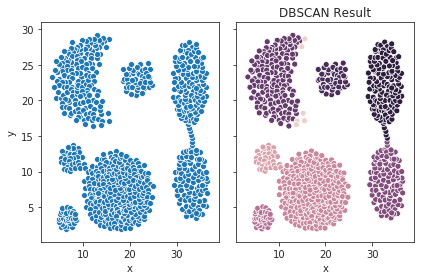

In [85]:
final_dict = {} 
for key, value in info_dict.items():
    final_dict = dict(final_dict.items()+value.items())

plot_result(final_dict, "ticks")